# Processamento de linguagem natural

***

## Importando bibliotecas

In [1]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Classes do modelo
from sklearn.linear_model import LogisticRegression

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Análise do conjunto de dados

**HatEval** : Este conjunto de dados faz parte da competição SemEval 2019 Task 5 [(Basile et al., 2019)](https://aclanthology.org/S19-2007.pdf) que consiste na detecção de discurso de ódio contra imigrantes e mulheres. Vamos consider apenas a subtarefa A English, um problema de classificação binária para detectar se um tweet em inglês contém discurso de ódio. Mais informações sobre o conjunto de dados HatEval podem ser encontradas em sua página do GitHub: https://github.com/msang/hateval.

In [2]:
# Esse dataset já é dividido em treinamento, teste e validação
train = pd.read_csv("https://raw.githubusercontent.com/Francimaria/especializacao_DNN/main/datasets/hateval/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/Francimaria/especializacao_DNN/main/datasets/hateval/test.csv")
val = pd.read_csv("https://raw.githubusercontent.com/Francimaria/especializacao_DNN/main/datasets/hateval/val.csv")

Vamos observar algumas características de dataset

Quantidade de exemplos em cada conjunto

 TREINAMENTO: 9000

 TESTE: 3000

 VALIDAÇÃO: 1000

 Distribuição dos dados por classe


Text(0.5, 1.0, 'Validação')

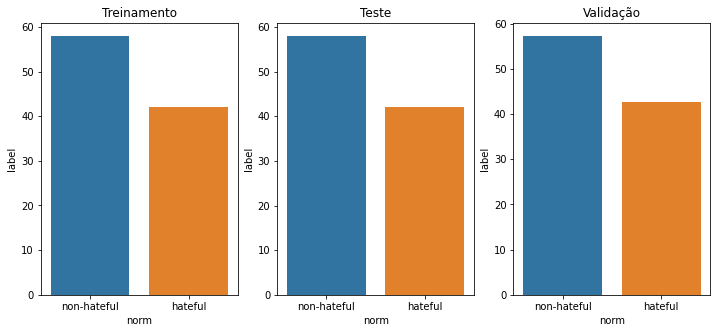

In [3]:
# Distribuição dos dados por 
print("Quantidade de exemplos em cada conjunto")

print("\n TREINAMENTO:", train.shape[0])

print("\n TESTE:", test.shape[0])

print("\n VALIDAÇÃO:", val.shape[0])

print("\n Distribuição dos dados por classe")

fig, ax = plt.subplots(1,3, figsize=(12,5))
#percentual 
sns.barplot(x="norm", y="label",  data=train,ax=ax[0], order=["non-hateful", "hateful"],  estimator=lambda x: len(x) / len(train) * 100)
ax[0].set_title("Treinamento")
sns.barplot(x="norm", y="label", data=test, ax=ax[1], order=["non-hateful", "hateful"], estimator=lambda x: len(x) / len(test) * 100)
ax[1].set_title("Teste")
sns.barplot(x="norm", y="label", data=val, ax=ax[2], order=["non-hateful", "hateful"], estimator=lambda x: len(x) / len(val) * 100)
ax[2].set_title("Validação")

# Se quiser visualizar a contagem 
# sns.countplot(x="label", data=train, ax=ax[0])
# sns.countplot(x="label", data=test, ax=ax[1])
# sns.countplot(x="label", data=val, ax=ax[2])

# 58%: non-hateful 
# 42%: hateful

**Vamos observar os dados**

* Features: texto em linguagem natural

* Características do texto: obtido a partir de redes sociais (Twitter). Possui alguns elementos como: menções (“i.e.,$@usuario$"), URLs ( “$http[s]://$"), RT símbolos, números e etc.




In [4]:
# primeiramente vamos observar os dados
with pd.option_context('display.max_colwidth',None):
  display(train.head(5))#

,index,text,label,norm
0,201,"Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike",1,hateful
1,202,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn",1,hateful
2,203,"@KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe",1,hateful
3,204,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6,0,non-hateful
4,205,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX",0,non-hateful


## pré-processamento

A etapa de pré-processamento é responsável por preparar os dados para a etapa de extração de características. 

Nessa etapa podem ser realizadas diferentes tarefas como:  

* Limpeza dos dados: remoção de menções (“i.e.,$@usuario$"), URLs ( “$http[s]://$"), RT símbolos, números, stop-words e espaços em branco redundantes.

* Normalização dos dados: conversão do texto completo para minúsculo e normalização de unicode [link](https://www.ibm.com/docs/en/db2-for-zos/11?topic=ccsids-normalization-unicode-strings).


Verificar a biblioteca [NLTK](https://www.nltk.org/)



In [5]:
import nltk                                             # Natural Language Toolkit

nltk.download('stopwords')

import re                                               # biblioteca para operações com regular expression
from nltk.corpus import stopwords                       # módulo para tratamento das stop words que vem com o NLTK
import string                                           # para operações com string
from unicodedata import normalize                       # para normalização de unicodes

[nltk_data] Downloading package stopwords to /home/npi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# se quiser visualizar a lista de stopwords
stops = set(stopwords.words('english'))
print(stops)
print("Quantidade: ",len(stops))
# os idiomas também podem ser usados 
stops = set(stopwords.words('portuguese'))
print(stops)
print("Quantidade: ",len(stops))
stops = set(stopwords.words('spanish'))
print(stops)
print("Quantidade: ",len(stops))

{"needn't", 'why', 'our', 'himself', 'having', 'll', 'some', 'for', 'about', 'd', 'ain', "aren't", 'don', 'because', 'you', 'only', 'both', 'theirs', 'have', 'when', 'mustn', 'weren', 'won', 'me', 'm', "mustn't", 'off', 'his', 'ourselves', 'here', 'this', 'can', 'who', 'whom', 'from', 'further', 'o', 'myself', 'yours', 'a', 'the', 'my', 'at', 'more', "couldn't", 'he', 'haven', 'they', 'i', "it's", "won't", 'if', 'between', 'not', 'which', 'few', 'your', "that'll", 'down', "should've", 'an', 'while', 'ma', 'before', 'hadn', 'up', 'shouldn', 'their', 'its', 'to', 'each', 'by', 're', 'during', 's', "doesn't", 'any', 'doesn', 'doing', 'again', 'aren', "haven't", 'than', 'same', 'above', 'couldn', 'all', 'other', "don't", 'as', 'am', 'hasn', 've', 'these', "you've", 'been', 'out', 'so', 'nor', 'that', 'had', "weren't", 'against', 'below', 'isn', 'do', 'them', 'in', 'just', "you'd", 'being', "wouldn't", 'is', 'wasn', "hasn't", 'until', "didn't", 'most', 'has', 'of', 't', 'were', 'then', 'y',

In [7]:
# vamos checar alguns exemplos
# Diferentes unicodes para gerar a mesma letra
print("\u00C7", "\u0043\u0327")

print("Ç" == "Ç")

print("Ç"=="Ç")

Ç Ç
False
True


In [8]:
def clear_replace(text):
    """
    1) Substituição de muitos espaços em branco por uma instância
    2) Remoção de RT, urls, menções, números
    3) Normalização de unicode

    Retorne o texto pré-processado
    """

    # padrão muitos espaços em branco
    space_pattern = '\s+'

    # padrão de RT
    rt_regex = 'RT @[\w_]+'    

    # padrão para urls
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    # padrão para menções
    mention_regex = '@[\w\-]+'

    #padrão para números
    number_regex = '[0-9]'

    # Removendo espaços extras
    parsed_text = re.sub(space_pattern, ' ', text)
    
    #Removendo RT
    parsed_text = re.sub(rt_regex, ' ', parsed_text) 

    # Removendo URLs    
    parsed_text = re.sub(giant_url_regex, ' ', parsed_text)

    # Removendo menções
    parsed_text = re.sub(mention_regex, ' ', parsed_text)

    # Removendo números
    parsed_text = re.sub(number_regex, ' ', parsed_text)

    # Normalização de unicode
    parsed_text = normalize('NFKD', parsed_text).encode('ASCII', 'ignore').decode('ASCII')
    
    return parsed_text

In [9]:
def to_lower(text):
  """ Transforme o texto em minúsculo"""
  return text.lower()

In [10]:
def remove_stopwords(text):
	""" Use NLTK para remover todas as stop-words em inglês """
	stop_words = set(stopwords.words('english'))  #portuguese

	return ' '.join([word for word in text.split() if word not in stop_words])

In [11]:
def pre_processing(tweets):	
	clean_tweets = []

	for text in tweets:
		#Limpando o texto
		text = clear_replace(str(text))
		#Conversão do texto completo para minúsculo
		text = to_lower(text)
		# Removendo stopwords
		text = remove_stopwords(text)
		clean_tweets.append(text)
	return clean_tweets

In [32]:
# vamos verificar um exemplo. Vou colocar em português, mas para o HatEval dataset as stopwords devem ser em inglês. 

exemplo_1 = "RT @chiquinho Quem te falou       ISSO?"

exemplo_2 = "ELA ama trabalhar com NLP 5 dias por semana https://www.nltk.org/, apenas"

tweets = [exemplo_1 , exemplo_2]

pre_processing(tweets)

['quem te falou isso?', 'ela ama trabalhar com nlp dias por semana apenas']

In [13]:
# Vamos avaliar apenas um subset dos conjuntos de treinamento, teste e validação com 10% dos exemplos
train_sub, _, _,_ = train_test_split(train, train["label"], train_size=0.1, stratify=train["label"], random_state=42)
test_sub, _, _,_ = train_test_split(test, test["label"], train_size=0.1, stratify=test["label"], random_state=42)
val_sub, _, _,_ = train_test_split(val, val["label"], train_size=0.1, stratify=val["label"], random_state=42)

print(train_sub.shape[0])
print(test_sub.shape[0])
print(val_sub.shape[0])

900
300
100


In [14]:
train_sub["text"] = pre_processing(train_sub["text"])
test_sub["text"] = pre_processing(test_sub["text"])
val_sub["text"] = pre_processing(val_sub["text"])

_X_train, y_train = train_sub["text"], train_sub["label"]
_X_test, y_test = test_sub["text"], test_sub["label"]
_X_val, y_val = val_sub["text"], val_sub["label"]

# primeiramente vamos observar os dados
with pd.option_context('display.max_colwidth',None):
  display(_X_train.head(5))

788                                                                      heart trump #trumptrain #buildthatwall
6394                              bri: put hole- me: *starts laughing like child* bri: *starts laughing* whoops
1717    wait turn...guyanese immigrant explains ny post agrees us president, donald trump's immigration policy.
4511                                     ok fucking said leave block me. dm first i'm gonna kick ass. shut fuck
6541                          back. even crowley. 'cause everything done, owe us, son bitch. get ass here, make
Name: text, dtype: object

## Extração de características

Como representar uma palavra? 

Em PLN os conjuntos de dados geralmente estão disponíveis como texto bruto para análise. Portanto, a extração de características visa transformar o texto em linguagem natural em um espaço vetorial numérico adequado como entradas do modelo. Várias técnicas de extração de características podem ser aplicadas, como técnicas de Bag-of-Words (BoW), recursos lexicais e métodos de embedding.


Vamos utilizar o TF-IDF (frequency–inverse document frequency). O TF-IDF é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

$$TFIDF (t, d, D) = tf (t, d) \times idf (t, D)$$

tf - frequência absoluta

idf - A frequência inversa do documento é uma medida de quanta informação a palavra fornece, ou seja, se é comum ou rara em todos os documentos

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(_X_train)
X_test = vectorizer.transform(_X_test)
X_val = vectorizer.transform(_X_val)

In [16]:
#vamos verificar o tamanho do vetor

print(X_train.shape)

(900, 4083)


In [17]:
print(vectorizer.get_feature_names_out())
print("Número de features:", len(vectorizer.get_feature_names_out()))

## com o pré-processamento: 4153
## sem o pré-processamento: 5182

['2ythats' 'a_x' 'aap' ... 'zeebrugge' 'zero' 'zone']
Número de features: 4083


Vamos testar agora um modelo pré-treinado 

In [18]:
!pip install zeugma

Defaulting to user installation because normal site-packages is not writeable


In [19]:
from zeugma.embeddings import EmbeddingTransformer

fastText = EmbeddingTransformer('fasttext-wiki-news-subwords-300')

X_train_f = fastText.fit_transform(_X_train)
X_test_f = fastText.transform(_X_test)
X_val_f = fastText.transform(_X_val)


2024-03-23 12:59:26.764929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 12:59:26.864548: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 12:59:26.868267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-23 12:59:26.868280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

## Treinando o modelo

 Vamos avaliar o modelo usando a regressão logistica

In [20]:
model = LogisticRegression(random_state=42)

#treinando o modelo
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
print(classification_report(y_test, y_pred))

# 0 - non-hateful
# 1 - hateful

              precision    recall  f1-score   support

           0       0.51      0.24      0.32       174
           1       0.40      0.69      0.50       126

    accuracy                           0.43       300
   macro avg       0.45      0.46      0.41       300
weighted avg       0.46      0.43      0.40       300



## E se ajustarmos os parâmetros

In [21]:
model = LogisticRegression(random_state=42)

#penalty - depende do algoritmo usado para otimização (solver) padrão: ‘lbfgs’ - [‘l2’, None]
# 'none': nenhuma penalidade é adicionada;
# 'l2': adiciona um termo de penalidade L2 e é a escolha padrão;

parameters = {'penalty': ['L2', 'none']}

grid = GridSearchCV(estimator = model,             
                    param_grid = parameters,     
                    scoring = 'f1_macro',          # métrica de avaliação
                    cv = 5)                        # cross-validation

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print("Melhor parametro:", grid.best_params_)         
# e ver a sua performance no dataset de teste

Melhor parametro: {'penalty': 'none'}


In [22]:
#Treinando o modelo final com o parâmetro selecionado 
model = LogisticRegression(penalty='none', random_state=42)
model.fit(X_train, y_train)

#predição
y_pred = model.predict(X_test)

#Resultados do classificador
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.21      0.30       174
           1       0.42      0.78      0.54       126

    accuracy                           0.45       300
   macro avg       0.49      0.49      0.42       300
weighted avg       0.50      0.45      0.40       300



### E se quisermos gerar um modelo que faça a extração e a classificação sequencialmente


In [23]:
X_train, y_train = train_sub["text"], train_sub["label"]
X_test, y_test = test_sub["text"], test_sub["label"]
X_val, y_val = val_sub["text"], val_sub["label"]

X_train.head(3)

788                heart trump #trumptrain #buildthatwall
6394    bri: put hole- me: *starts laughing like child...
1717    wait turn...guyanese immigrant explains ny pos...
Name: text, dtype: object

### Vamos salvando os resultados em um dataframe



In [24]:
# Vamos importar algumas métricas

from sklearn.metrics import (auc, accuracy_score, f1_score)

In [25]:
# Vamos usar um dataFrame para ir salvando os resultados
# adicione outras métricas 
df_results = pd.DataFrame(columns=['modelo', 'acuracia'])
df_results

,modelo,acuracia


In [26]:
# Modelo 1
from sklearn.pipeline import Pipeline

pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('lr', LogisticRegression(random_state=42))])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)


acc = accuracy_score(y_test, y_pred)
#round value
acc = round(acc, 2)

#f_score = f1_score(y_test, y_pred, average='macro')

# Adicione o resultado no dataframe 
# criando uma nova linha para adicionar no dataFrame
new_row = {'modelo': 'modelo 1','acuracia': acc}
df_results = df_results.append(new_row, ignore_index=True)
print("Acurácia: %.3f" %acc)
df_results


Acurácia: 0.430


,modelo,acuracia
0,modelo 1,0.43


In [27]:
# Modelo 2

# ajustando os parâmetros 
model =  Pipeline([('tfidf', TfidfVectorizer()),
                  ('lr', LogisticRegression(random_state=42))])

# Nos parâmetros precisamos especificar a qual etapa ele pertence (nome__) * Obs.: são dois underlines (__)
parameters = {'lr__penalty': ['L2', 'none']}

grid = GridSearchCV(estimator = model,             # k-nn
                    param_grid = parameters,       # dicionário com valores para serem testados.
                    scoring = 'accuracy',          # métrica de avaliação #f1_macro
                    cv = 5)                        # cross-validation

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
#round value
acc = round(acc, 2)

#f_score = f1_score(y_test, y_pred, average='macro')

# Adicione o resultado no dataframe 
# criando uma nova linha para adicionar no dataFrame
new_row = {'modelo': 'modelo 2','acuracia': acc}
df_results = df_results.append(new_row, ignore_index=True)
print("Acurácia: %.3f" %pipe.score(X_test, y_test))

print("Melhor parametro:", grid.best_params_)     
display(df_results)

Acurácia: 0.427
Melhor parametro: {'lr__penalty': 'none'}


,modelo,acuracia
0,modelo 1,0.43
1,modelo 2,0.45


# Avalie o modelo com outros classificadores 

Que tal testar o mlp?

Obs.: Lembre que precisamos realizar a extração de características 

Use o random_state=20

## 

In [29]:
# Modelo 3

from sklearn.neural_network import MLPClassifier



# Use um pipeline 



## Escolha um dos modelo visto em aula para classificação 

**Use o random_state=42 e o tfidf como extrator de características**
